In [66]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [67]:
H = 400
W = 400
f = 1200

In [68]:
rays_o = np.zeros((H*W, 3))
rays_d = np.zeros((H*W, 3))

In [69]:
u = np.arange(W)
v = np.arange(H)

In [70]:
u, v = np.meshgrid(u, v)

In [71]:
dirs = np.stack((u - W/2,
                 -(v - H/2),
                 -np.ones_like(u) * f), axis=-1)
rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
rays_d = rays_d.reshape(-1, 3)

In [72]:
def plot_rays(o, d, t):

  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(projection = '3d')

  pt1 = o
  pt2 = o + d * t

  for p1, p2 in zip(pt1, pt2):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]])

  plt.show()

In [73]:
# plot_rays(rays_o, rays_d, 1)

In [74]:
class Sphere():

  def __init__(self, p, r, c):
    self.p = p
    self.r = r
    self.c = c

  def intersect(self, x):
    """
    :param x: points[batch_size, 3]
    """

    cond = (x[:, 0] - self.p[0])**2 + (x[:, 1] - self.p[1])**2 + (x[:, 2] - self.p[2])**2 < self.r**2

    num_rays = x.shape[0]
    colors = torch.zeros((num_rays, 3))
    density = torch.zeros((num_rays, 1))

    colors[cond] = self.c
    density[cond] = 10

    return colors, density

In [75]:
s = Sphere(np.array([0, 0, -1]), 0.1, np.array([1, 0, 0]))

In [76]:
def compute_accumulated_transmittance(betas):
  accumulated_transmittance = torch.cumprod(betas, 1)
  # accumulated_transmittance[:, 1:] = accumulated_transmittance[:, :-1]
  # accumulated_transmittance[:, 0] = 1.0
  return torch.cat((torch.ones(accumulated_transmittance.shape[0], 1, device=accumulated_transmittance.device),
                    accumulated_transmittance[:, :-1]), dim=1)

In [77]:
def rendering(model, rays_o, rays_d, tn, tf, nb_bins=100, device="cpu"):

  t = torch.linspace(tn, tf, nb_bins).to(device)
  delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10])))

  x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1)

  colors, density = model.intersect(x.reshape(-1, 3))

  colors = colors.reshape((x.shape[0], nb_bins, 3)) # [nb_bins, nb_bins, 3]
  density = density.reshape((x.shape[0], nb_bins))

  alpha = 1 - torch.exp(-density * delta.unsqueeze(0)) # [nb_bins, nb_bins, 1]
  T = compute_accumulated_transmittance(1 - alpha) # [nb_bins, nb_bins, 1]

  c = (T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors).sum(1)

  return c

In [78]:
model = Sphere(torch.tensor([0, 0, -1]), 0.1, torch.tensor([1., 0., 0.]))
b = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 0.8, 1.2)

c_to_optimize = torch.tensor([0., 0., 0.], requires_grad=True)

optimizer = torch.optim.SGD({c_to_optimize}, lr=1e-2)

In [79]:
c_to_optimize.grad

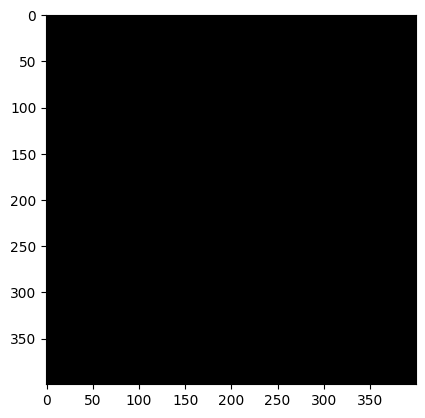

0.049365926533937454
tensor([0.0010, 0.0000, 0.0000], requires_grad=True)


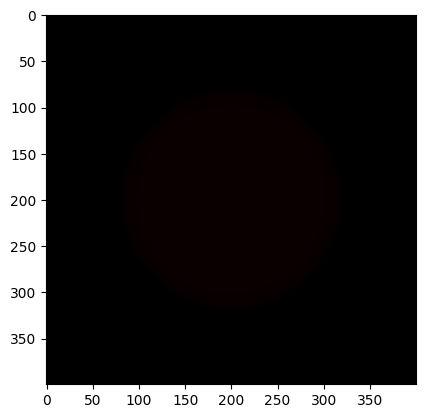

0.044195014983415604
tensor([0.0645, 0.0000, 0.0000], requires_grad=True)


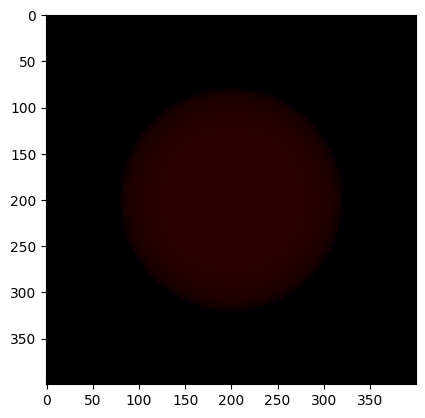

0.03157028928399086
tensor([0.2196, 0.0000, 0.0000], requires_grad=True)


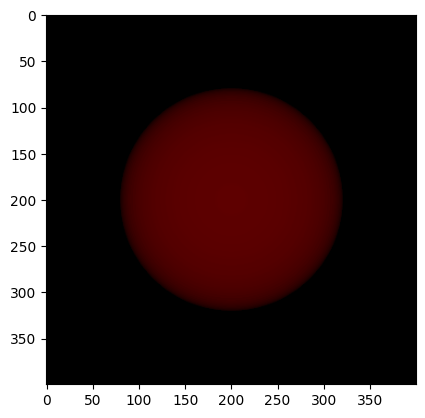

0.01631602831184864
tensor([0.4511, 0.0000, 0.0000], requires_grad=True)


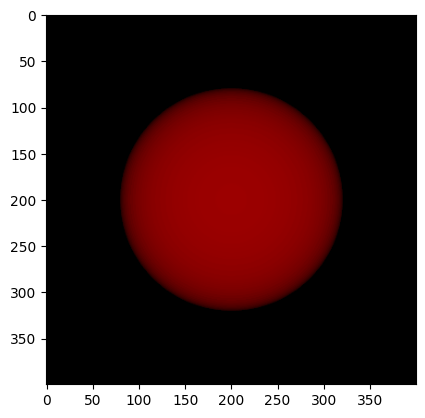

0.004261359106749296
tensor([0.7364, 0.0000, 0.0000], requires_grad=True)


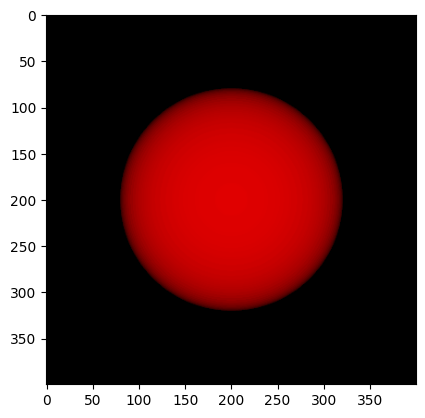

1.2736420103465207e-05
tensor([1.0475, 0.0000, 0.0000], requires_grad=True)


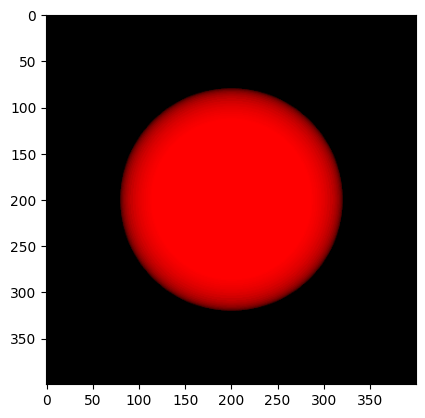

0.005193688906729221
tensor([1.3539, 0.0000, 0.0000], requires_grad=True)


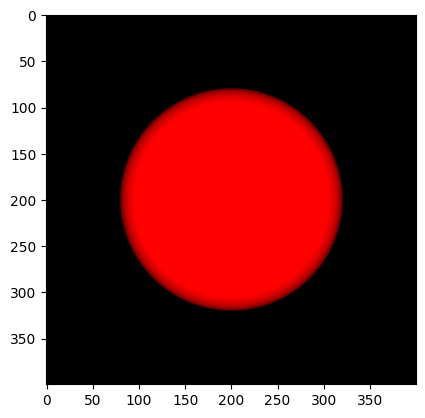

0.017824407666921616
tensor([1.6257, 0.0000, 0.0000], requires_grad=True)


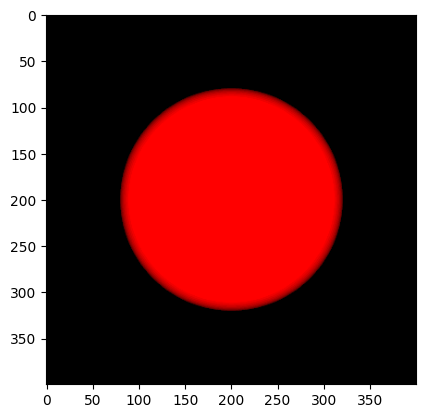

0.033078309148550034
tensor([1.8362, 0.0000, 0.0000], requires_grad=True)


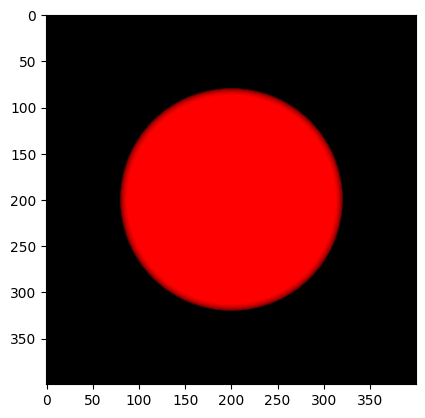

0.04512642323970795
tensor([1.9648, 0.0000, 0.0000], requires_grad=True)


In [80]:
for epoch in range(100):

  model = Sphere(torch.tensor([0, 0, -1]), 0.1, c_to_optimize)
  Ax = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 0.8, 1.2)

  loss = ((Ax - b)**2).mean()
  loss.backward()
  optimizer.step()

  if epoch % 10 == 0:
    img = Ax.reshape(H, W, 3).cpu().data.numpy()
    plt.imshow(img)
    plt.show()

    print(loss.item())
    print(c_to_optimize)